In [4]:
import tensorflow as tf

bazel run tensorflow/examples/wav_to_spectrogram:wav_to_spectrogram -- \
--input_wav=/home/pi/Desktop/Wav_files/bat_record_01b16.wav \
--output_image=/tmp/spectrogram.png

SyntaxError: invalid syntax (<ipython-input-4-52b608045a5a>, line 3)

In [3]:
import tensorflow as tf
# Requires latest tf-1.4 on Windows
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
def parse_wave_tf(filename):
    audio_binary = tf.read_file(filename)
    desired_channels = 1
    wav_decoder = contrib_audio.decode_wav(
        audio_binary,
        desired_channels=desired_channels)
    with tf.Session() as sess:
        sample_rate, audio = sess.run([
            wav_decoder.sample_rate,
            wav_decoder.audio])
        first_sample = audio[0][0] * (1 << 15)
        second_sample = audio[1][0] * (1 << 15)
        print('''
Parsed {filename}
-----------------------------------------------
Channels: {desired_channels}
Sample Rate: {sample_rate}
First Sample: {first_sample}
Second Sample: {second_sample}
Length in Seconds: {length_in_seconds}'''.format(
            filename=filename,
            desired_channels=desired_channels,
            sample_rate=sample_rate,
            first_sample=first_sample,
            second_sample=second_sample,
            length_in_seconds=len(audio) / sample_rate))
        print(audio)
parse_wave_tf('/home/pi/Desktop/Wav_files/bat_record_01b16.wav')



Parsed /home/pi/Desktop/Wav_files/bat_record_01b16.wav
-----------------------------------------------
Channels: 1
Sample Rate: 192000
First Sample: -930.0
Second Sample: -1024.0
Length in Seconds: 0.06127604166666667
[[-0.02838135]
 [-0.03125   ]
 [-0.03146362]
 ...
 [-0.05014038]
 [-0.05145264]
 [-0.06558228]]


In [1]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))









b'Hello, TensorFlow!'


In [110]:
import struct
import binascii
from struct import unpack

bits_per_sample = 24
sub_chunk_2_size = 10000
samples = []
bytes_per_sample = bits_per_sample / 8
sample_count = int(sub_chunk_2_size / bytes_per_sample)

with open('/home/pi/untitled7.wav', 'rb') as wav_file:
    chunk_id = wav_file.read(4)  # See the WAVE file format docs
    chunk_size = struct.unpack('<I', wav_file.read(4))[0]
    for _ in range(sample_count):
        samples.append(struct.unpack('<h', wav_file.read(2))[0])
print(chunk_id)

b'RIFF'.decode('ascii') == 'RIFF'
'RIFF'.encode('ascii') == b'RIFF'

print(samples)



b'RIFF'
[16727, 17750, 28006, 8308, 16, 0, 3, 1, -4608, 2, -18432, 11, 4, 32, 24934, 29795, 4, 0, 10125, 0, 17744, 19265, 16, 0, 1, 0, 30905, 23914, 16384, 15719, 1114, 0, 24932, 24948, -25036, 0, 0, 15170, 0, 15208, 0, 14896, 0, -17764, 0, 14736, 0, 14832, 0, -17642, 0, -17626, 0, 14888, 0, 14960, 0, -17808, 0, 14720, 0, 14768, 0, -17920, 0, -17920, 0, -17756, 0, -17776, 0, 15114, 0, 15154, 0, 14880, 0, -18240, 0, -17848, 0, -17888, 0, 14848, 0, 14528, 0, 14888, 0, 14904, 0, -17788, 0, -17780, 0, -18240, 0, -17652, 0, -17624, 0, 14848, 0, 15104, 0, 14944, 0, 14952, 0, 14872, 0, 14988, 0, 15060, 0, 14720, 0, -17716, 0, -17712, 0, 0, 0, 15036, 0, 14968, 0, -17912, 0, -18304, 0, -17736, 0, -17832, 0, -17984, 0, -17562, 0, -17652, 0, 15056, 0, 15122, 0, 15114, 0, 15068, 0, 15044, 0, 15096, 0, 15120, 0, 14980, 0, -17652, 0, -17566, 0, -17534, 0, -17600, 0, 0, 0, 15126, 0, 15036, 0, -17840, 0, -18176, 0, 14848, 0, 14592, 0, -18432, 0, 15040, 0, 15192, 0, 15114, 0, -17724, 0, -17708, 0, -178

In [80]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win


    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

    plt.clf()
plotstft("untitled2.wav")

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [75]:
from pydub import AudioSegment
from pydub.silence import split_on_silence

sound = AudioSegment.from_wav("r20160418005459.wav")
chunks = split_on_silence(sound, 
    # must be silent for at least ... milliseconds
    min_silence_len=1,

    # consider it silent if quieter than -16 dBFS
    #silence_thresh=-16
    silence_thresh= -80
)
l = len(chunks)
print(l)
for i, chunk in enumerate(chunks):
    chunk.export("/home/pi/chunk{0}.wav".format(i), format="wav")

1


In [99]:
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.utils import make_chunks
import csv
import os

audio = "untitled2.wav"
audio1 = "test.wav"
audio2 = "test2.csv"

#a = AudioSegment.from_wav(untitled2) first_second=a[:1000]
#print(a)

#s = AudioSegment.from_wav(audio)first_second = s[:1000] 
#read wav file and export with 16bit bitrate
s = AudioSegment.from_file(audio, format = "wav" )
s.export(audio1 , bitrate="16", format="wav")
# s.export(audio2 , bitrate="24", format="txt")
#read modified file
rate, data = wavfile.read(audio1)

#print(data)
#print(rate)
#print(s)

# x = np.array([1e-16,1,2,3])
# print(np.array2string(data, precision=2, separator=',',suppress_small=True))
x = np.array2string(data, precision=2, separator=',',suppress_small=True)

print(x)

#cool = "cool°"

cool = x.rstrip('\n')
cool = cool.rstrip(']')
cool = cool.rstrip('[')
# \r or \n. 
#print(cool)
#cool

# open a file for writing:

f = open("file.csv", "w")

f.write(x)

f.close()

[ -711, -580,  -15,  591,  782,  379, -292, -774, -636,    8,  631,  861,
   416, -426, -972, -823, -103,  767, 1076,  564, -424,-1102, -883,   51,
  1023, 1251,  511, -651,-1347,-1079,  -14, 1054, 1315,  569, -623,-1338,
 -1061,   62, 1195, 1413,  654, -571,-1442,-1205,  -57, 1050, 1375,  645,
  -525,-1323,-1198, -132, 1060, 1479,  773, -526,-1376,-1211, -158,  985,
  1447,  785, -401,-1264,-1255, -376,  795, 1452, 1044, -131,-1180,-1420,
  -686,  583, 1393, 1227,  216, -945,-1463, -975,  259, 1307, 1425,  573,
  -701,-1462,-1249,  -89, 1142, 1576,  835, -531,-1480,-1406, -409,  947,
  1629, 1173, -146,-1334,-1606, -700,  715, 1683, 1497,  241,-1204,-1851,
 -1202,  279, 1519, 1658,  621, -869,-1676,-1311,  -47, 1306, 1725, 1008,
  -356,-1470,-1588, -623,  752, 1621, 1300,   48,-1253,-1766,-1011,  500,
  1665, 1682,  582, -827,-1665,-1398, -193, 1142, 1629,  977, -285,-1365,
 -1570, -691,  759, 1688, 1443,  181,-1177,-1764,-1144,  233, 1450, 1667,
   777, -596,-1573,-1480, -376,  947, 

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


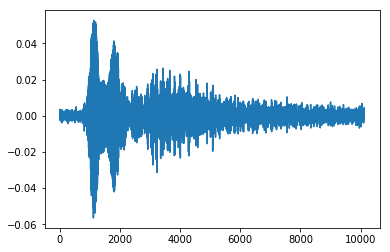

In [1]:
# import math functions
from math import *
import matplotlib.pyplot as plt
import numpy as np
from array import *
import matplotlib.pyplot as plt

# Set the plot size:
plt.rcParams['figure.figsize'] = [50, 25]

import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
rate, data = wav.read('untitled7.wav')
%matplotlib inline
plt.plot(data)
plt.show()

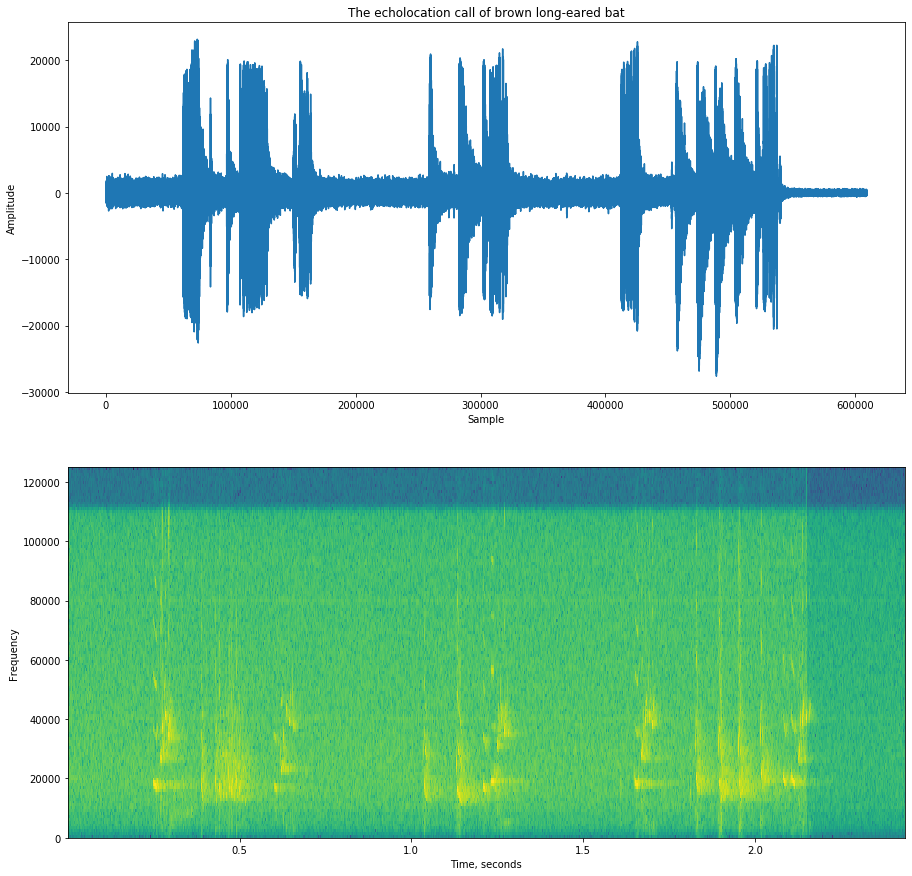

In [2]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('/home/pi/Desktop/Wav_files/pipipipisocial.wav')
# bat_record_01b13.wav
# bat_record_01bearlynormalised01.wav

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [10, 10]
plot.subplot(211)

plot.title('The social call of the common pipistrelle ')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/pi/Desktop/Wav_files/pipipipisocial.wav'

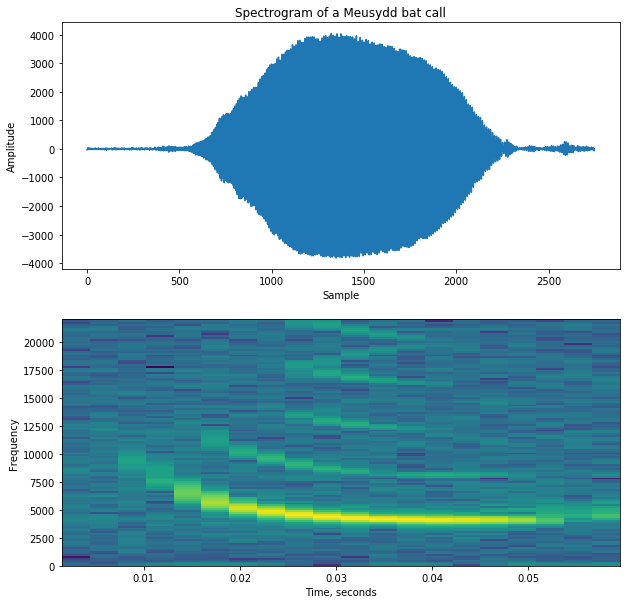

In [2]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('/home/pi/Desktop/Wav_files/pipipipi.wav')
# bat_record_01b13.wav
# bat_record_01bearlynormalised01.wav

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [10, 10]
plot.subplot(211)

plot.title('The echolocation call of the common pipistrelle ')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

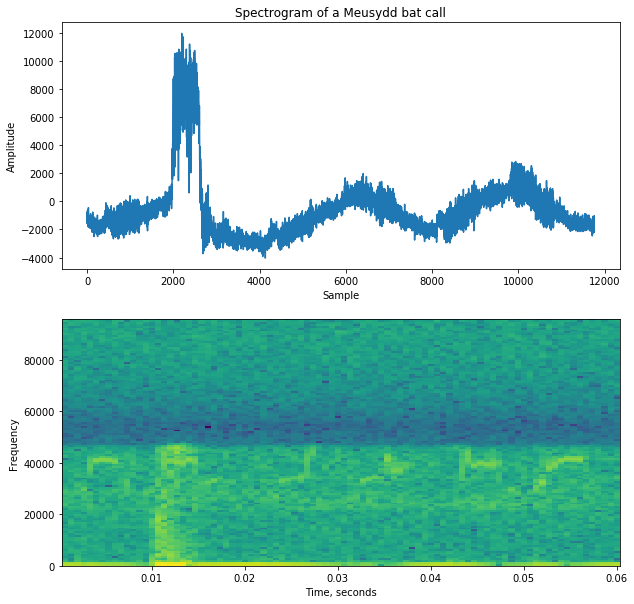

In [8]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('/home/pi/Desktop/Wav_files/bat_record_01b16.wav')
# bat_record_01b13.wav
# bat_record_01bearlynormalised01.wav

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [10, 10]
plot.subplot(211)

plot.title('Spectrogram of a Meusydd bat call')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

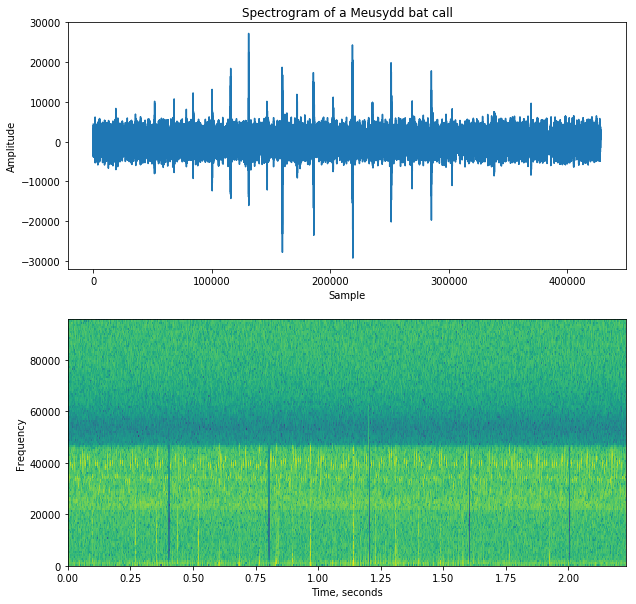

In [6]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('/home/pi/Desktop/Wav_files/bat_record_01b14.wav')
# bat_record_01b13.wav
# bat_record_01bearlynormalised01.wav

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [10, 10]
plot.subplot(211)

plot.title('Spectrogram of a Meusydd bat call')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

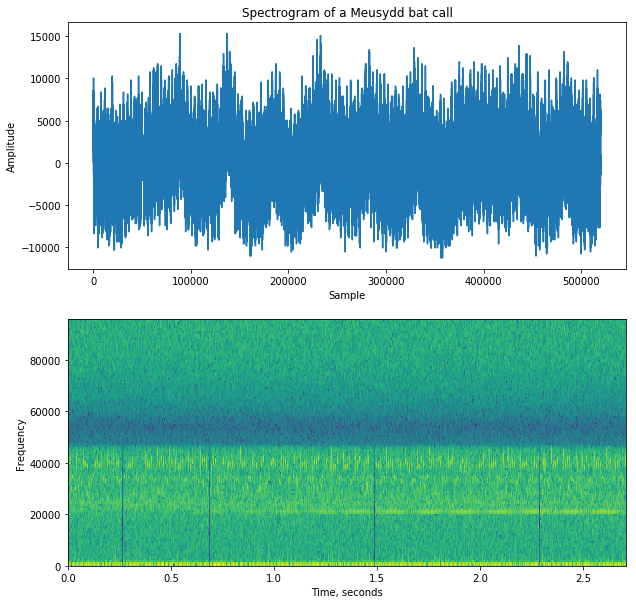

In [4]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('/home/pi/Desktop/Wav_files/bat_record_01bearlynormalised01.wav')
# bat_record_01b13.wav
# bat_record_01bearlynormalised01.wav

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [10, 10]
plot.subplot(211)

plot.title('Spectrogram of a Meusydd bat call')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


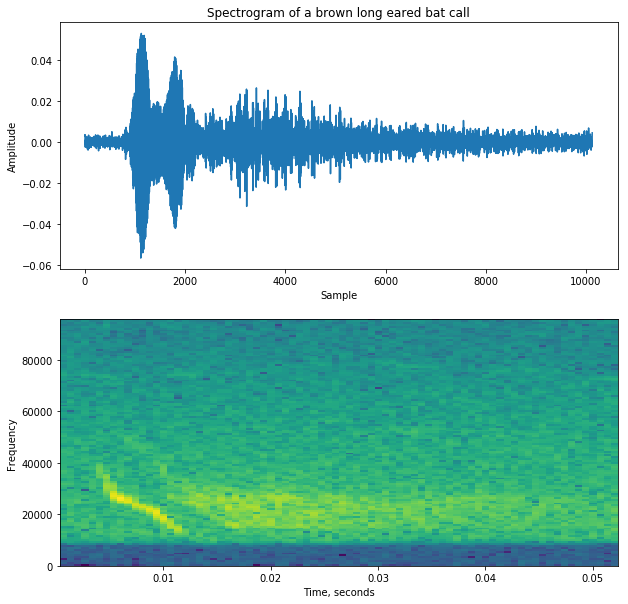

In [2]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('untitled7.wav')

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [10, 10]
plot.subplot(211)

plot.title('Spectrogram of a brown long eared bat call')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

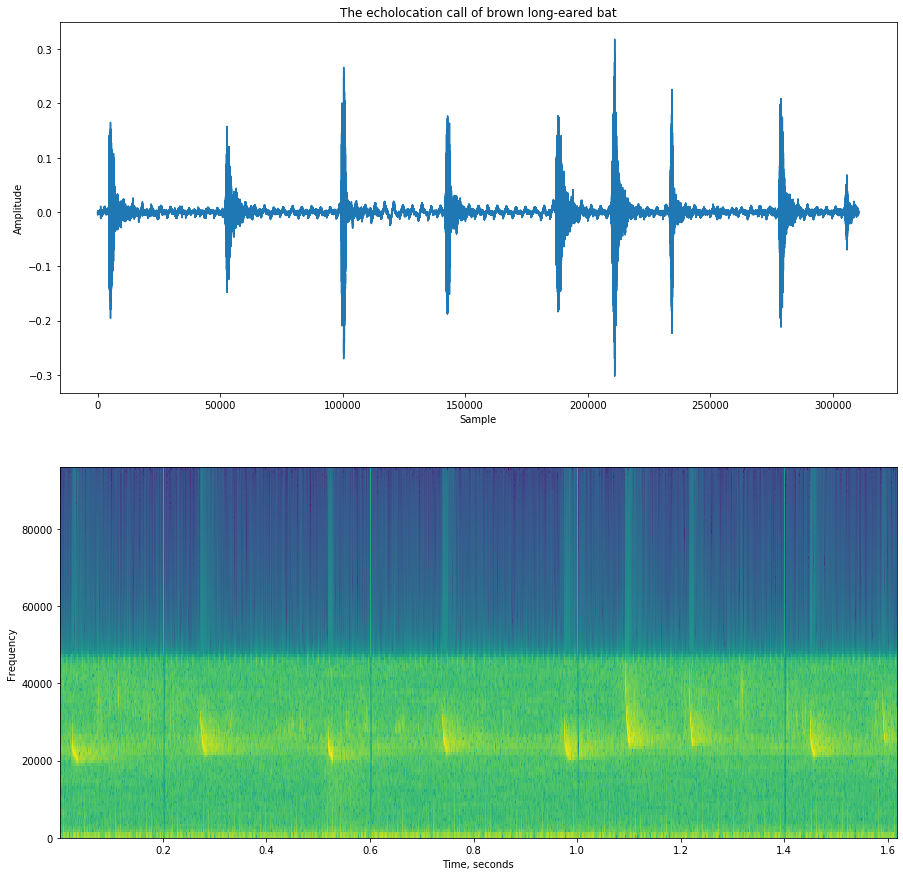

In [2]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

# samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Friday_6_sept/clip_28_25.wav')
# samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Friday_6_sept/Lower_freq_clip_35_55c.wav')
# samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Friday_6_sept/clip_8_07d.wav')
# samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/bat_calls_dot_com/Nyctalus_noctula_3_o.wav')
# samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/bat_calls_dot_com/Pipistrellus_pipistrellus_2_o.wav')
# samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Wav_files/test04.wav')
samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/Probably_noctule_02.wav')



# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [15, 15]
plot.subplot(211)

plot.title('The echolocation call of brown long-eared bat')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()

In [ ]:
# Audio processing starts here!

In [ ]:
from pydub import AudioSegment

def detect_leading_silence(sound, silence_threshold=-35.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

In [14]:
from pydub import AudioSegment
from pydub.silence import split_on_silence
import os
import glob
from pydub import AudioSegment

# sound = AudioSegment.from_wav("/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/Probably_noctule_02.wav")
sound = AudioSegment.from_wav("/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/Probably_common_pipistrelle_and_noctule_01.wav")

chunks = split_on_silence(sound, 
    # must be silent for at least ... milliseconds
    min_silence_len=4,
    silence_thresh= -35
)
l = len(chunks)
print(l)
for i, chunk in enumerate(chunks):
    chunk.export("/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/chunk{0}.wav".format(i), format="wav")

5


In [26]:
import os
import glob
from pydub import AudioSegment
from pydub.utils import db_to_float
import re

audio_dir = '/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/'  # Path where the calls are located
os.chdir(audio_dir)

duo = dict()
processed = dict()

for i in range (l):
    
    x = "chunk" + str(i-1) + ".wav"
    y = "chunk" + str(i) + ".wav"
    z = str(i)
    
    processed[z] = "processed" + str(i)

    if i > 0:
        duo[z] = AudioSegment.from_wav(x) + AudioSegment.from_wav(y)
        
        start_trim = detect_leading_silence(duo[z])
        end_trim = detect_leading_silence(duo[z].reverse())

        duration = len(duo[z])    
        trimmed_sound = duo[z][start_trim:duration-end_trim]
        duo[z] = trimmed_sound
        # save the results
        duo[z].export(processed[z], format="wav")

In [16]:
from pydub import AudioSegment

def detect_leading_silence(sound, silence_threshold=-35.0, chunk_size=10):
    '''
    sound is a pydub.AudioSegment
    silence_threshold in dB
    chunk_size in ms

    iterate over chunks until you find the first one with sound
    '''
    trim_ms = 0 # ms

    assert chunk_size > 0 # to avoid infinite loop
    while sound[trim_ms:trim_ms+chunk_size].dBFS < silence_threshold and trim_ms < len(sound):
        trim_ms += chunk_size

    return trim_ms

sound = AudioSegment.from_file("/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/processed1", format="wav",
                             channels=1 )


start_trim = detect_leading_silence(sound)
end_trim = detect_leading_silence(sound.reverse())

duration = len(sound)    
trimmed_sound = sound[start_trim:duration-end_trim]
# save the result
trimmed_sound.export("trimmed_sound", format="wav")

<_io.BufferedRandom name='trimmed_sound'>

In [17]:
# Overlay with 350 ms silence:
sound2 = AudioSegment.from_file("trimmed_sound" , channels=1 )
sound1 = AudioSegment.from_file("350ms_silence.wav" , channels=1 )

played_togther = sound1.overlay(sound2)
played_togther = played_togther.set_channels(1)
played_togther.export("played_togther2", format="wav" )

<_io.BufferedRandom name='played_togther2 '>

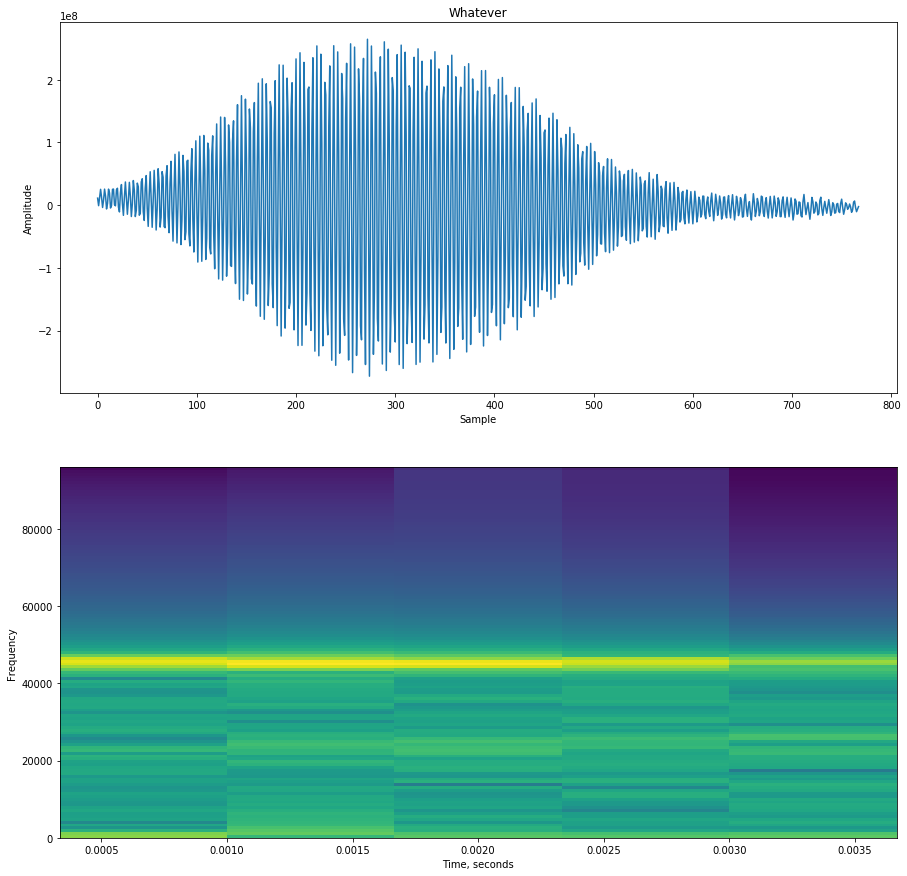

In [28]:
import matplotlib.pyplot as plot
from scipy.io import wavfile
# Read the wav file (mono)

samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/processed3')
#samplingFrequency, signalData = wavfile.read('/media/tegwyn/Xavier_SD/Bat_Detecter/Sunday_8_Sept/played_togther2')

# Plot the signal read from wav file
plot.rcParams['figure.figsize'] = [15, 15]
plot.subplot(211)

plot.title('Whatever')

plot.plot(signalData)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)

plot.specgram(signalData,Fs=samplingFrequency)
plot.xlabel('Time, seconds')
plot.ylabel('Frequency')

plot.show()